In [1]:
import fastf1
from fastf1 import utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
plt.style.use('dark_background')


In [2]:
from fastf1.utils import delta_time
import fastf1.plotting

## Data

In [3]:
session = fastf1.get_session(2025,'Spain','Q')
session.load(laps=True, weather=True, telemetry=True)

req         WARNING 	DEFAULT CACHE ENABLED! (611.78 MB) C:\Users\Sanket\AppData\Local\Temp\fastf1


core           INFO 	Loading data for Spanish Grand Prix - Qualifying [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 

## Practice Analysis

In [42]:
print(f'{pd.DataFrame(session.laps.pick_accurate()['LapTime'].dt.total_seconds().describe()).T['75%'].values[0]:.3f}')

81.345


In [45]:
session.laps.columns

Index(['Time', 'Driver', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint',
       'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time',
       'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime',
       'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'IsPersonalBest',
       'Compound', 'TyreLife', 'FreshTyre', 'Team', 'LapStartTime',
       'LapStartDate', 'TrackStatus', 'Position', 'Deleted', 'DeletedReason',
       'FastF1Generated', 'IsAccurate'],
      dtype='object')

In [65]:
for i, row in session.laps.pick_accurate().iterrows():
    test = pd.DataFrame(row.get_telemetry(frequency=30))
    print(row[['Driver','DriverNumber','LapNumber']])
    break

Driver          VER
DriverNumber      1
LapNumber       2.0
dtype: object


In [72]:
print(float(f'{test['Speed'].mean():.2f}'),test['Speed'].max())

225.62 329.0


## Qualifying Analysis

In [4]:
session.laps[['Driver','LapTime','LapNumber','Stint']]

,Driver,LapTime,LapNumber,Stint
0,PIA,NaT,1.0,1.0
1,PIA,0 days 00:01:12.551000,2.0,1.0
2,PIA,0 days 00:01:43.593000,3.0,1.0
3,PIA,NaT,4.0,2.0
4,PIA,0 days 00:01:56.012000,5.0,2.0
...,...,...,...,...
242,TSU,0 days 00:01:13.847000,2.0,1.0
243,TSU,0 days 00:01:47.322000,3.0,1.0
244,TSU,NaT,4.0,2.0
245,TSU,0 days 00:01:13.385000,5.0,2.0


In [5]:
q1,q2,q3 = session.laps.split_qualifying_sessions()
q1 = q1.pick_accurate()
q2 = q2.pick_accurate()
q3 = q3.pick_accurate()

In [6]:
p1 = 'PIA'
p2 = 'NOR'

### P1,P2 Comparison

In [7]:
d_p1 = q3.pick_driver(p1).pick_fastest().get_telemetry(frequency=20).add_distance()
d_p2 = q3.pick_driver(p2).pick_fastest().get_telemetry(frequency=20).add_distance()

In [8]:
delta_time, ref_tel, compare_tel = utils.delta_time(q3.pick_driver(p1).pick_fastest(), q3.pick_driver(p2).pick_fastest())

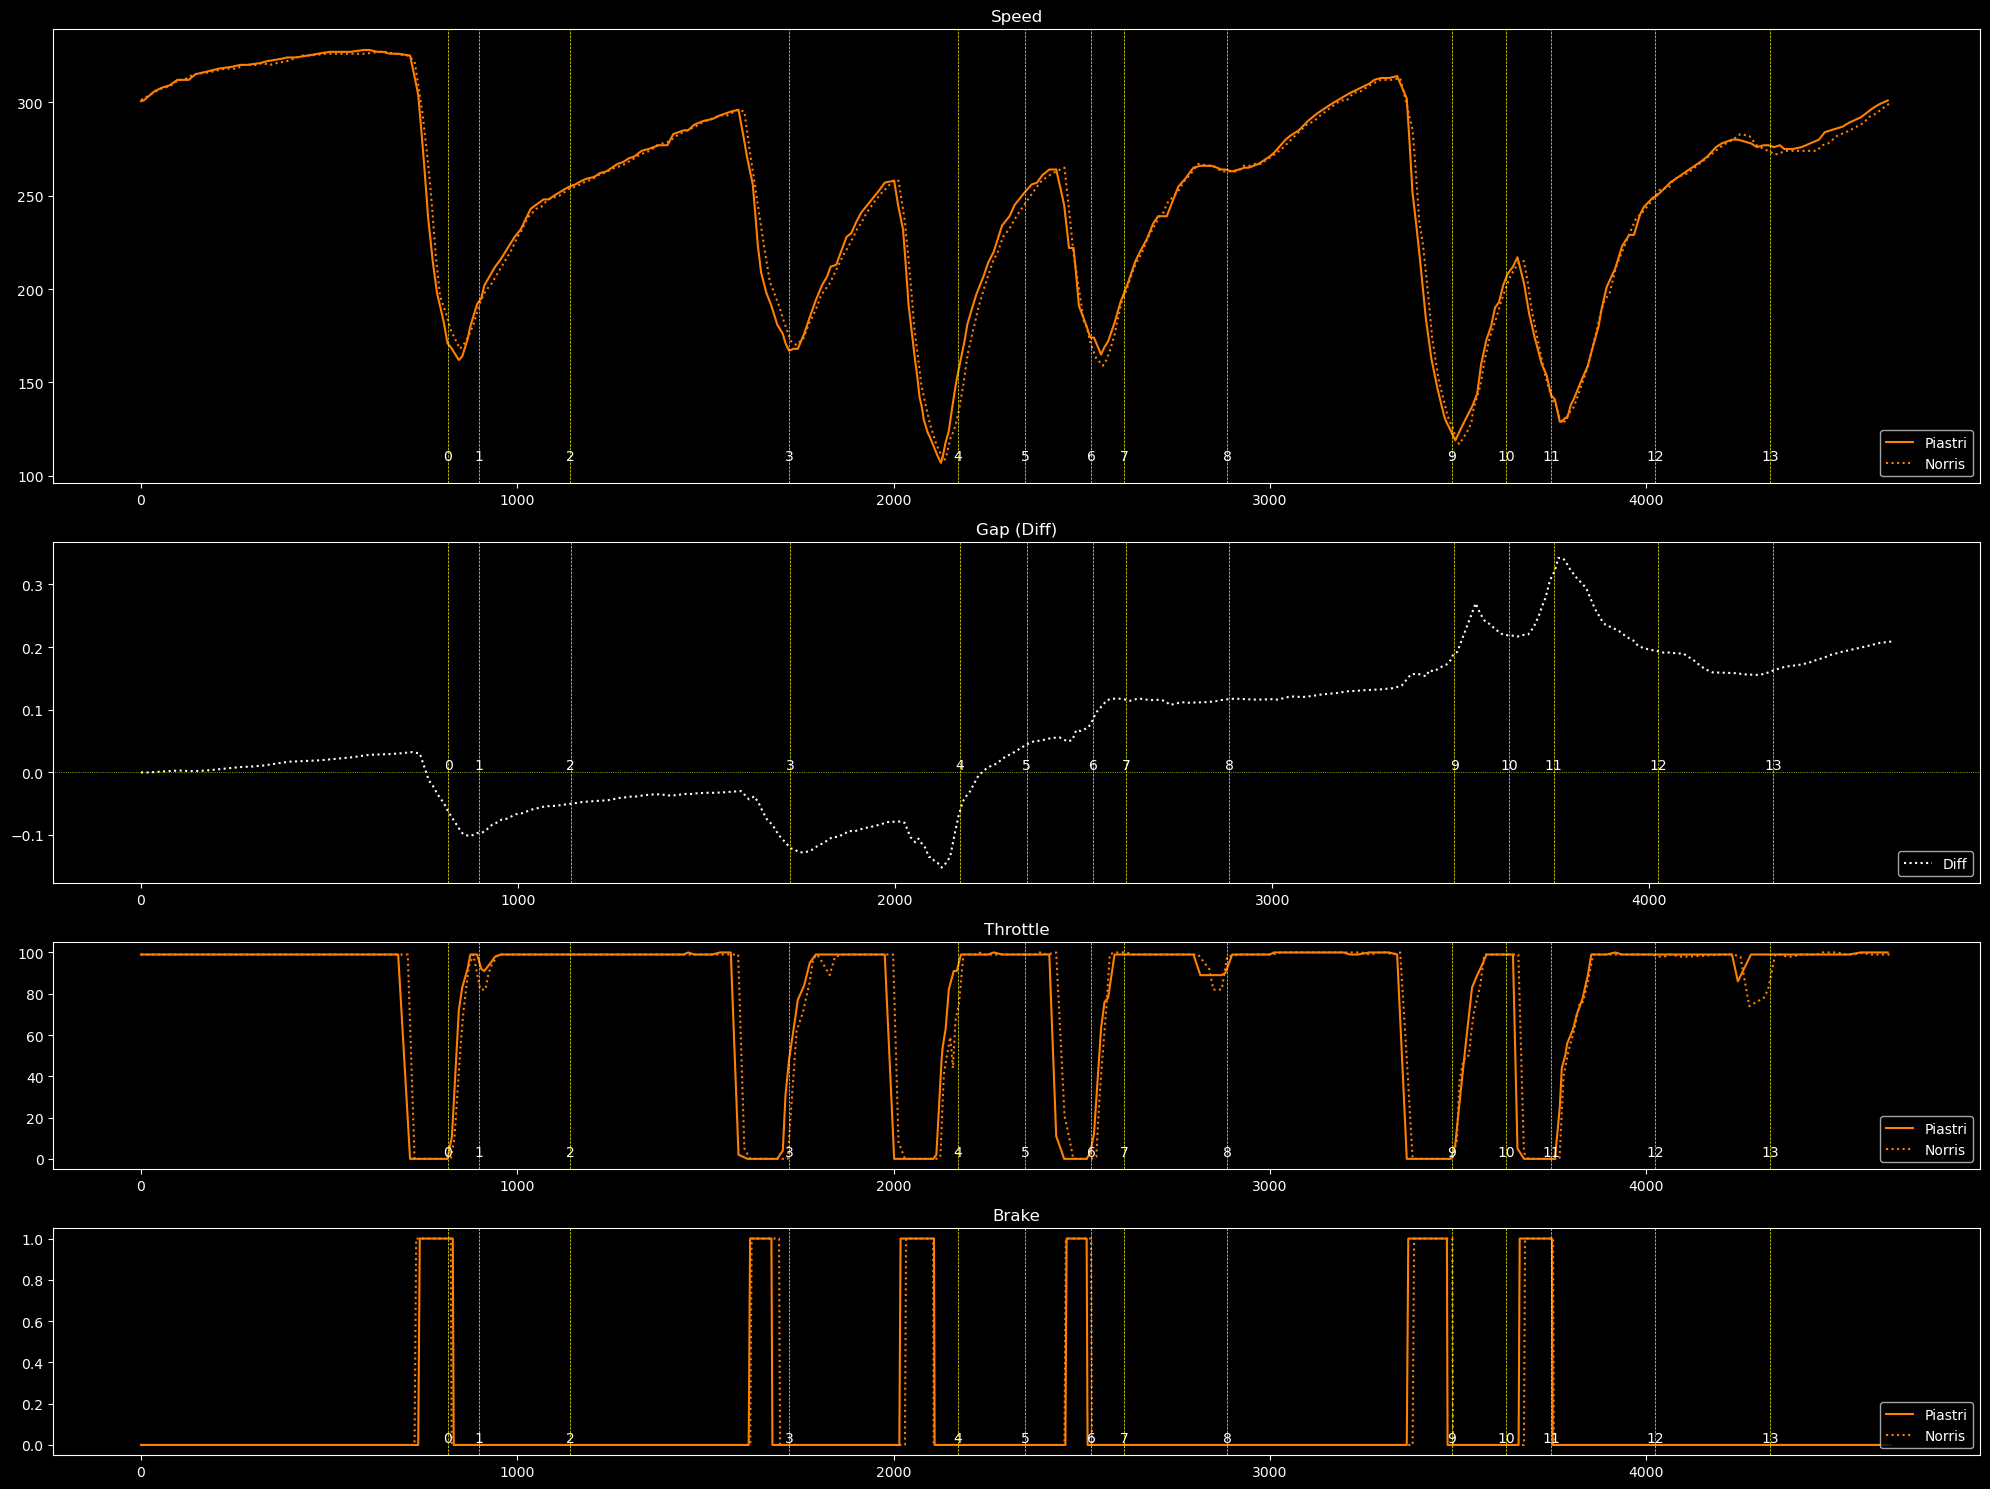

In [187]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(20, 15))
gs = gridspec.GridSpec(4, 1, height_ratios=[1, 0.75, 0.5, 0.5])  # Define grid with different heights


# Speed Plot
ax0 = fig.add_subplot(gs[0])
ax0.plot(d_p1['Distance'], d_p1['Speed'], label=session.get_driver(p1)['LastName'], color=fastf1.plotting.get_driver_color(p1,session=session))
ax0.plot(d_p2['Distance'], d_p2['Speed'], label=session.get_driver(p2)['LastName'], color=fastf1.plotting.get_driver_color(p2,session=session), linestyle='dotted')
for corner_index in range(len(session.get_circuit_info().corners)):
    ax0.axvline(x=session.get_circuit_info().corners['Distance'][corner_index], color='yellow', linestyle='--', linewidth=0.5)
    ax0.text(session.get_circuit_info().corners['Distance'][corner_index], session.laps.pick_fastest().get_telemetry().Speed.min(), f'{corner_index}', ha='center', va='bottom')
ax0.legend(loc='lower right')
ax0.set_title("Speed")

# Gap (Diff) Plot
ax1 = fig.add_subplot(gs[1])
ax1.plot(ref_tel['Distance'],delta_time, label='Diff', color='white',linestyle='dotted')
ax1.axhline(y=0, color='yellow', linestyle='dotted', linewidth=0.5)
for corner_index in range(len(session.get_circuit_info().corners)):
    ax1.axvline(x=session.get_circuit_info().corners['Distance'][corner_index], color='yellow', linestyle='--', linewidth=0.5)
    ax1.text(session.get_circuit_info().corners['Distance'][corner_index], 0, f'{corner_index}', ha='center', va='bottom')
ax1.legend(loc='lower right')
ax1.set_title("Gap (Diff)")

# Throttle Plot
ax2 = fig.add_subplot(gs[2])
ax2.plot(d_p1['Distance'], d_p1['Throttle'], label=session.get_driver(p1)['LastName'], color=fastf1.plotting.get_driver_color(p1,session=session))
ax2.plot(d_p2['Distance'], d_p2['Throttle'], label=session.get_driver(p2)['LastName'], color=fastf1.plotting.get_driver_color(p2,session=session), linestyle='dotted')
for corner_index in range(len(session.get_circuit_info().corners)):
    ax2.axvline(x=session.get_circuit_info().corners['Distance'][corner_index], color='yellow', linestyle='--', linewidth=0.5)
    ax2.text(session.get_circuit_info().corners['Distance'][corner_index], 0, f'{corner_index}', ha='center', va='bottom')
ax2.legend(loc='lower right')
ax2.set_title("Throttle")

# Brake Plot
ax3 = fig.add_subplot(gs[3])
ax3.plot(d_p1['Distance'], d_p1['Brake'], label=session.get_driver(p1)['LastName'], color=fastf1.plotting.get_driver_color(p1,session=session))
ax3.plot(d_p2['Distance'], d_p2['Brake'], label=session.get_driver(p2)['LastName'], color=fastf1.plotting.get_driver_color(p2,session=session),linestyle='dotted')
for corner_index in range(len(session.get_circuit_info().corners)):
    ax3.axvline(x=session.get_circuit_info().corners['Distance'][corner_index], color='yellow', linestyle='--', linewidth=0.5)
    ax3.text(session.get_circuit_info().corners['Distance'][corner_index], 0, f'{corner_index}', ha='center', va='bottom')
ax3.legend(loc='lower right')
ax3.set_title("Brake")

plt.tight_layout()
plt.savefig(f'{format(session.session_info['StartDate'],'%Y')}_{session.session_info['Meeting']['Location']}_{session.session_info['Type']}_P1P2Comparison')

plt.show()

Norris had lot of corrections on his way 

-- Discussions

- The new Technical Directive regarding the front wing flexing was implemented for the race and as most of the people in paddock speculated about Mclaren using more flexing wings than what is allowed but Mclaren seems to have gained speed and lost drag instead of loosing the top speed. This technical derivative has strenghten Mclaren's advantage
- First sector was dominated by Norris but Piastri played a strategic game with being causious with tyre usage in the first sector so as to benefit in the remaining two sectors. This has been the talking point for the qualifying where drivers had to choose whether to fully push the tyre in the first sector or to save tyres for the remaining sectors. Norris used more tyre compared to Piastri visible through minimum speeds in the corners and Piastri used the remaining tyre in Next Sectors. This is also visible by the Minimum Speed on the corner. Also as Norris had used more tyre earlier, he was not consistent on the throttle due to high tyre temperatures. Summing everything, Piastri was a bit smarter and had understood how to get laptime from the car (Smart play from him)

### Car Setups

In [63]:
car_setups = []

In [64]:
for i in session.drivers:
    try:
        car_setups.append([i,session.get_driver(i)['LastName'],session.get_driver(i)['TeamName'],session.laps.pick_drivers(i).pick_fastest().get_telemetry().Speed.mean(),session.laps.pick_drivers(i).pick_fastest().get_telemetry().Speed.max()])
    except:
        pass

In [68]:
car_setups = pd.DataFrame(car_setups,columns=['Driver','DriverName','Team','MeanSpeed','TopSpeed'])
car_setups['SpeedRatio'] = car_setups['MeanSpeed']/car_setups['TopSpeed']
car_setups['SpeedRatio'] = car_setups['SpeedRatio'].apply(lambda x : np.round(x,3))

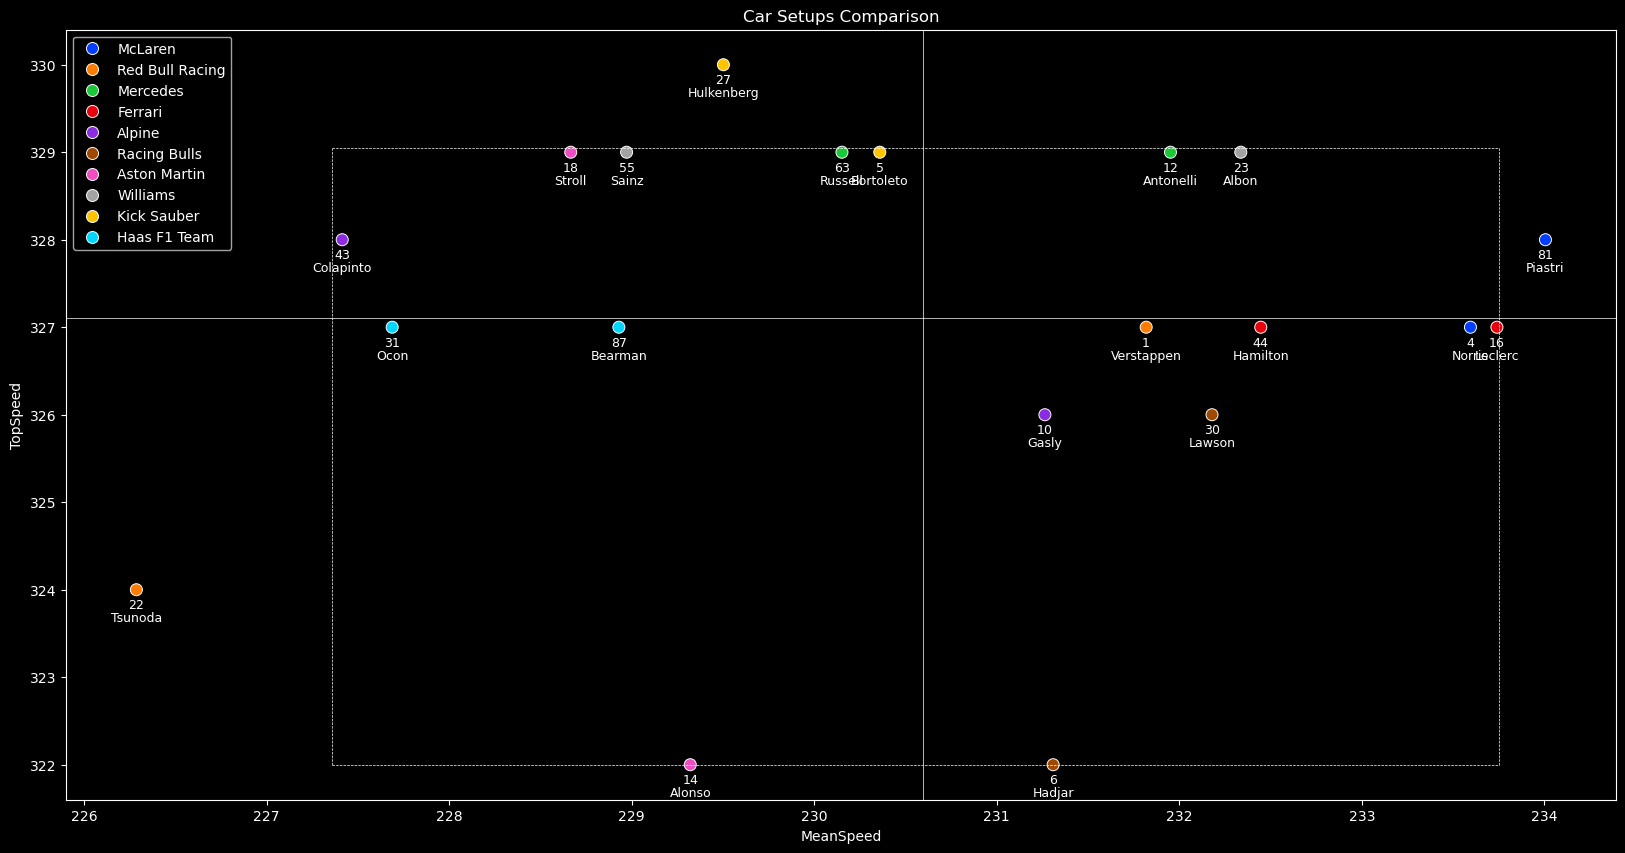

In [160]:
plt.figure(figsize=(20,10))
sns.scatterplot(data=car_setups,x='MeanSpeed',y='TopSpeed',hue='Team',palette='bright',s=75)

plt.axhline(car_setups['TopSpeed'].mean(),linewidth=0.5)
plt.hlines(car_setups['TopSpeed'].quantile(0.05),xmin=car_setups['MeanSpeed'].quantile(0.05),xmax=car_setups['MeanSpeed'].quantile(0.95),linestyle='dashed',linewidth=0.5)
plt.hlines(car_setups['TopSpeed'].quantile(0.95),xmin=car_setups['MeanSpeed'].quantile(0.05),xmax=car_setups['MeanSpeed'].quantile(0.95),linestyle='dashed',linewidth=0.5)

plt.axvline(car_setups['MeanSpeed'].mean(),linewidth=0.5)
plt.vlines(car_setups['MeanSpeed'].quantile(0.05),ymin=car_setups['TopSpeed'].quantile(0.05),ymax=car_setups['TopSpeed'].quantile(0.95),linestyle='dashed',linewidth=0.5)
plt.vlines(car_setups['MeanSpeed'].quantile(0.95),ymin=car_setups['TopSpeed'].quantile(0.05),ymax=car_setups['TopSpeed'].quantile(0.95),linestyle='dashed',linewidth=0.5)


for _, row in car_setups.iterrows():
    plt.text(row['MeanSpeed'], row['TopSpeed']-0.25, f'{row['Driver']}', fontsize=9, ha='center', va='bottom')
    plt.text(row['MeanSpeed'], row['TopSpeed']-0.25, f'{row['DriverName']}', fontsize=9, ha='center', va='top')

plt.legend()
plt.title('Car Setups Comparison')
plt.savefig(f'{format(session.session_info['StartDate'],'%Y')}_{session.session_info['Meeting']['Location']}_{session.session_info['Type']}_CarSetups.png')

plt.show()

-- Discussions

- Piastri is consistently outperforming in the Mclaren.
- Interestingly, looking at the car setups, the next best team after Mclaren is Ferrari. Looks like Ferrari has setup the car for Race by dropping some performance for Qualifying.
- Piastri (81), Tsunoda (22), Hulkenberg(27) are the outliers with Piastri outperforming in Mean Speed, Hulkenberg outperforming in TopSpeed and Tsuonda was very low in MeanSpeed

### Sector Leaders

## Race Analysis

### LapTime Boxplots

In [4]:
session.laps.columns

Index(['Time', 'Driver', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint',
       'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time',
       'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime',
       'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'IsPersonalBest',
       'Compound', 'TyreLife', 'FreshTyre', 'Team', 'LapStartTime',
       'LapStartDate', 'TrackStatus', 'Position', 'Deleted', 'DeletedReason',
       'FastF1Generated', 'IsAccurate'],
      dtype='object')

In [6]:
data = pd.DataFrame(session.laps.pick_accurate())[['Driver', 'LapNumber','Compound','LapTime']].sort_values('LapTime')

In [7]:
data['LapTime'] = data['LapTime'].dt.total_seconds()

In [10]:
data['LapTime'].min()

73.221

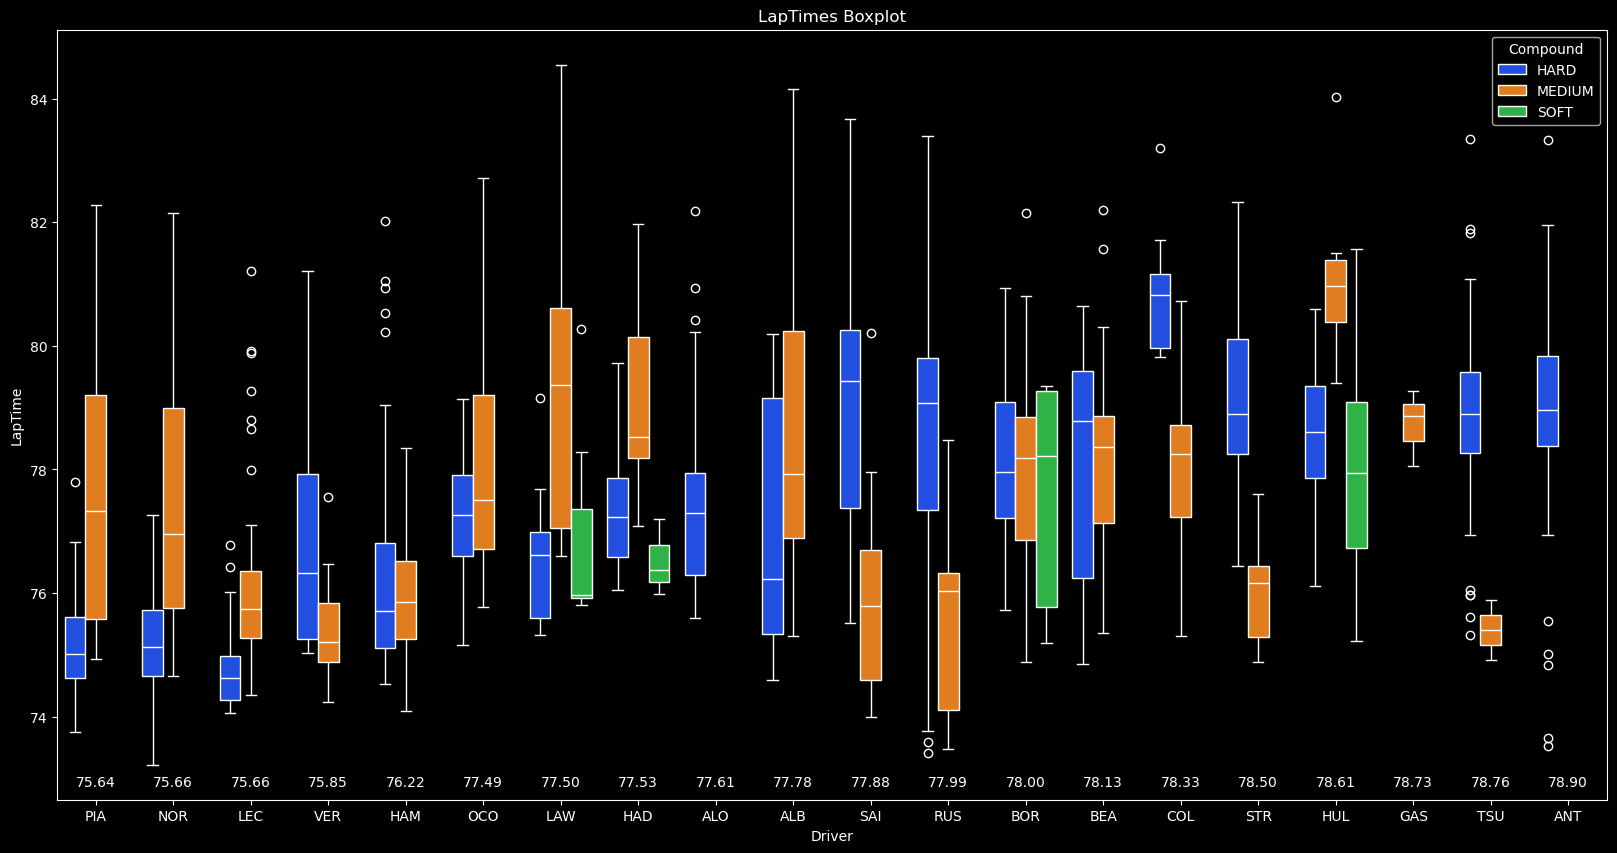

In [14]:
driver_order = data.groupby('Driver')['LapTime'].mean().sort_values().index
mean_lap_times = data.groupby('Driver')['LapTime'].mean()

plt.figure(figsize=(20,10))
sns.set_palette("bright")
sns.boxplot(data=data,x='Driver',y='LapTime',hue='Compound',order=driver_order,linecolor='white')

for i, driver in enumerate(driver_order):
    plt.text(i,data['LapTime'].min()-0.4, f"{mean_lap_times[driver]:.2f}", 
             ha='center', va='bottom', fontsize=10, color='white')
    
plt.title('LapTimes Boxplot')
plt.savefig(f'{format(session.session_info['StartDate'],'%Y')}_{session.session_info['Meeting']['Location']}_{session.session_info['Type']}_LapTimes')

### 0 - 200 acceleration

In [18]:
pd.DataFrame(session.laps.pick_driver('HAM').pick_lap(1).get_telemetry())

,Date,SessionTime,DriverAhead,DistanceToDriverAhead,Time,RPM,Speed,nGear,Throttle,Brake,DRS,Source,Distance,RelativeDistance,Status,X,Y,Z
2,2025-05-25 13:03:09.195,0 days 00:56:08.809000,,0.100000,0 days 00:00:00,9090.249984,0.000000,1,21.000000,False,1,interpolation,-0.001472,-4.361021e-07,OnTrack,-7610.993959,-7224.026400,503.000000
3,2025-05-25 13:03:09.235,0 days 00:56:08.849000,,0.100000,0 days 00:00:00.040000,9080.249984,0.000000,1,21.000000,False,1,pos,-0.000570,-1.687320e-07,OnTrack,-7611.000000,-7224.000000,503.000000
4,2025-05-25 13:03:09.252,0 days 00:56:08.866000,,0.100000,0 days 00:00:00.057000,9076.000000,0.000000,1,21.000000,False,1,car,0.000000,0.000000e+00,OnTrack,-7611.002976,-7223.986994,503.000000
5,2025-05-25 13:03:09.474,0 days 00:56:09.088000,,0.100000,0 days 00:00:00.279000,8969.316728,0.000000,1,21.000000,False,1,pos,0.015145,4.485866e-06,OnTrack,-7611.000000,-7224.000000,503.000000
6,2025-05-25 13:03:09.612,0 days 00:56:09.226000,81,0.100000,0 days 00:00:00.417000,8903.000000,0.000000,1,21.000000,False,1,car,0.000000,0.000000e+00,OnTrack,-7610.836354,-7224.715118,503.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
668,2025-05-25 13:04:38.493,0 days 00:57:38.107000,14,61.789167,0 days 00:01:29.298000,11670.000000,253.000000,6,100.000000,False,1,car,3332.772778,9.871582e-01,OnTrack,-7650.511947,-6803.023062,501.956935
669,2025-05-25 13:04:38.575,0 days 00:57:38.189000,14,61.675278,0 days 00:01:29.380000,11367.478099,254.464288,6,99.707142,False,1,pos,3338.601684,9.888847e-01,OnTrack,-7656.000000,-6722.000000,502.000000
670,2025-05-25 13:04:38.773,0 days 00:57:38.387000,14,61.400278,0 days 00:01:29.578000,10637.000000,258.000000,6,99.000000,False,1,car,3352.839444,9.931019e-01,OnTrack,-7661.494888,-6634.069536,501.948409
671,2025-05-25 13:04:38.836,0 days 00:57:38.450000,14,61.400278,0 days 00:01:29.641000,10578.134315,258.787501,6,93.093744,False,1,pos,3357.398353,9.944522e-01,OnTrack,-7663.000000,-6608.000000,502.000000


In [49]:
zero_twohundred = []

for i in session.drivers:
    tel = session.laps.pick_driver(i).pick_lap(1).get_telemetry()
    lap_time_sec = tel[tel['Distance'] <= session.get_circuit_info().corners[session.get_circuit_info().corners['Number']==1]['Distance'][0]]['Time'][-2:-1].dt.total_seconds().values
    if len(lap_time_sec) > 0:
        zero_twohundred.append([i, lap_time_sec[0]])
    else:
        zero_twohundred.append([i, None])

zero_twohundred = pd.DataFrame(zero_twohundred,columns=['Driver','Acceleration']).sort_values('Acceleration').reset_index(drop=True)

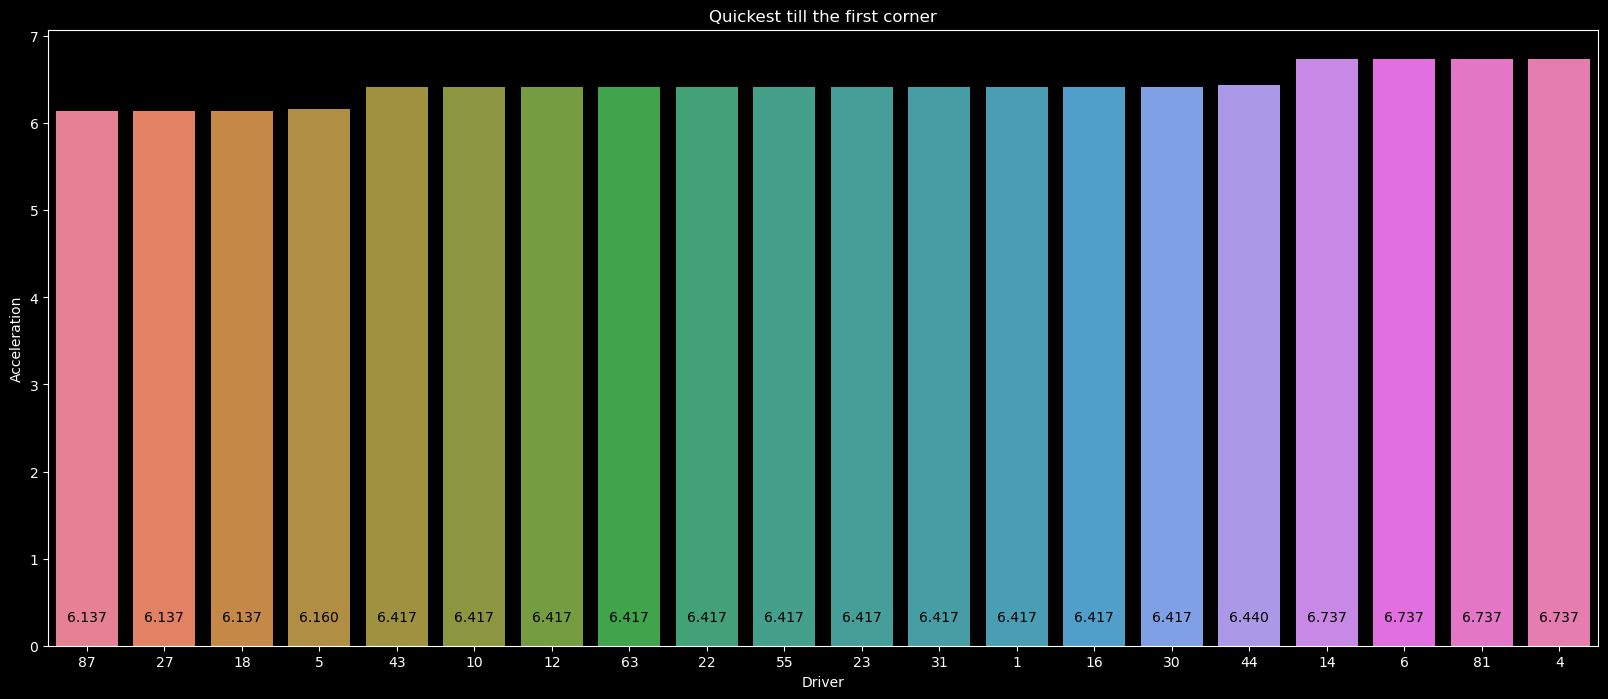

In [55]:
# Sort by Acceleration (ascending)
plt.figure(figsize=(20,8))
sns.barplot(data=zero_twohundred, x='Driver', y='Acceleration',hue='Driver')

for i, row in zero_twohundred.iterrows():
    plt.text(i,0.25, f"{row['Acceleration']:.3f}", ha='center', va='bottom', color='black', fontsize=10)


plt.title('Quickest till the first corner')

plt.savefig(f'{format(session.session_info['StartDate'],'%Y')}_{session.session_info['Meeting']['Location']}_{session.session_info['Type']}_ZeroHundred_Comparison')